In [2]:
%load_ext autoreload
%autoreload 2

## Shapley value defintion
Given a set of n elements, $U := \{1, \cdots, n\}$ and a function

$g: 2^U \rightarrow \mathbb{R}$ with $g(U) \neq 0$, $g(\varnothing)=0$

define $C(j|T) := g(T \cup \{j\}) - g(T)$ with $T \subseteq U$.

Feture i's contribution:

$\phi_i := \sum_{T \subseteq U} \frac{|T|! (n-1-|T|)!}{n!} C(i|T)$

where
$g(T) := f_T(x_T) - f(x')$ with $f_\varnothing(x_\varnothing) = f(x')$ for some baseline $x'$. 

$f_T(x_T) := \mathbb{E}[ f(x_T, X_{\bar{T}}) | z]$  where $z$ is a hyperparameter

previous approaches considers
- unconditional: $z := \varnothing$
- conditional: $z := \{X_T = x_T \}$

we in addition consider using a causal graph
- do: $z := \{do(X_T = x_T)\}$

## Assumptions
- no unobserved confounders

## Axioms

1. Any ordering of the source node is equally likely (eliminate reverse dfs)
2. Expanding a node won't affect the contribution of irrelevant edges (eliminate permutation of path and reverse dfs with single source by revealing the model node)
3. Efficiency
4. Linearity
5. NULL player

Want to show the dfs uniquely satisfies those axioms among path attribution methods. Edge attribution method is induced from the path attribution. 
Note that we don't have symmetry. Also note that axiom 1 may be eliminable.

## Noise distribution

For continuous variables, we assume data is generated through the data generating function with added Gaussian Noise (consistent with the assumption of regression problems).

For categorical variables, we assume the data is generated according to a categorical distribution, we perform inverse probability sampling by sampling from a uniform distribution.

In [44]:
import networkx as nx
from graphviz import Digraph, Source
from pygraphviz import AGraph
import numpy as np
import matplotlib.image as mpimg
from IPython.display import Image
import matplotlib.pyplot as plt
from flow import main, Node, CreditFlow, Graph, flatten_graph, eval_graph, get_source_nodes, single_source_graph, boundary_graph, viz_graph, save_graph

# 0 baseline model

$\text{health status} \in \{0, 1\}$

$\text{portable scanner} \in \{0, 1\}$

$\text{mortality probability prediction} \in [0, 1]$


```python
    x1 = Node('health status')
    n2 = Node('scanner type noise', is_noise_node=True) # U(0, 1)
    x2 = Node('scanner type', lambda x1, n2: int(0.9 > n2) if x1 <= 0.1 else int(0.3 > n2), [x1, n2])
    y  = Node('mortality prediction', lambda x1, x2: x2, 
              [x1, x2], is_target_node=True)
```

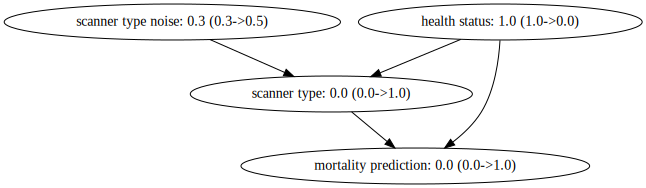


----> using order [scanner type noise, health status]
baselines scanner type noise: 0.3, health status: 1
turn on edge from external source to scanner type noise
scanner type noise changes from 0.3 to 0.5


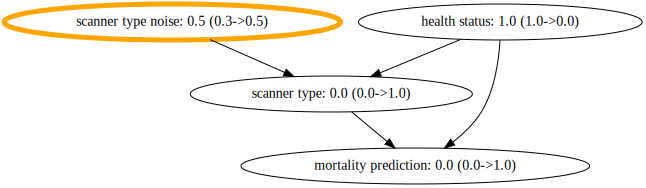

turn on edge scanner type noise->scanner type
scanner type changes from 0 to 0


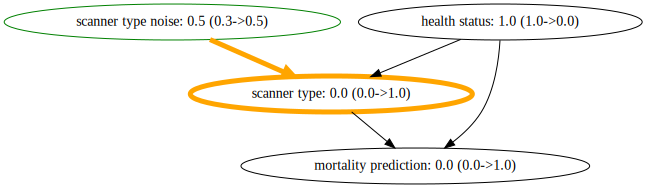

turn on edge scanner type->mortality prediction
mortality prediction changes from 0 to 0


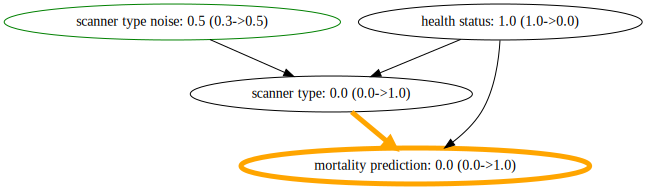

assign 0 credits to scanner type->mortality prediction


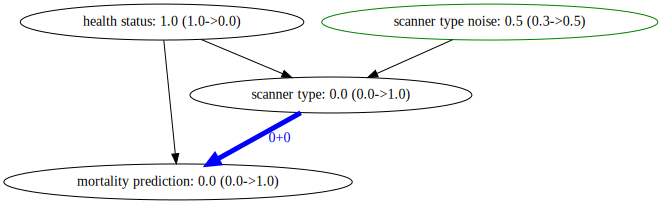

assign 0 credits to scanner type noise->scanner type


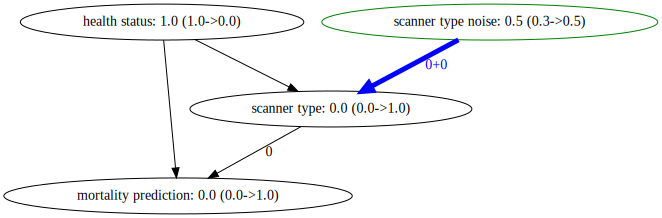

turn on edge from external source to health status
health status changes from 1 to 0


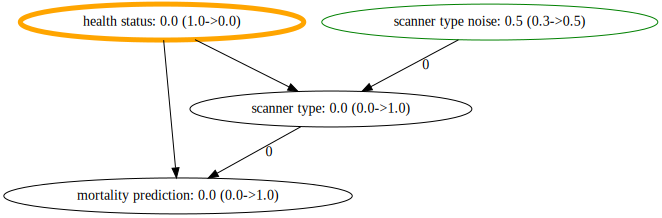

turn on edge health status->scanner type
scanner type changes from 0 to 1


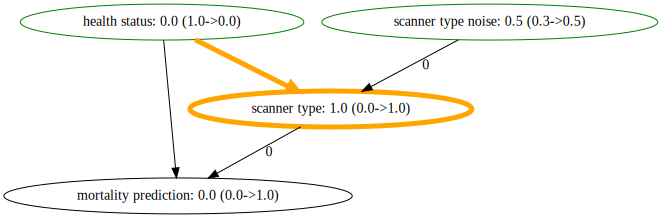

turn on edge scanner type->mortality prediction
mortality prediction changes from 0 to 1


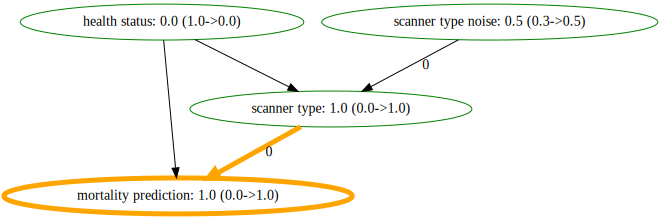

assign 1 credits to scanner type->mortality prediction


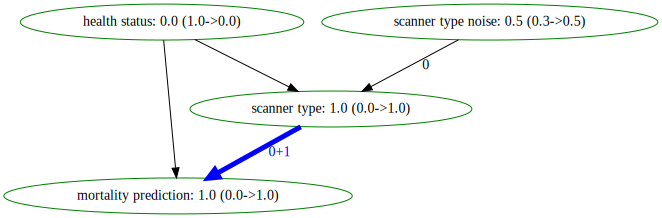

assign 1 credits to health status->scanner type


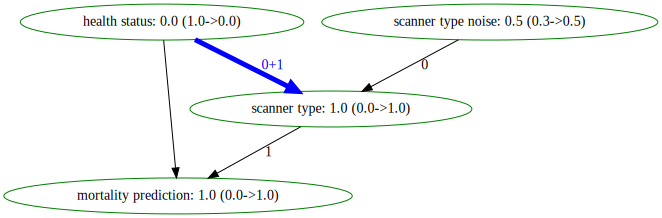

turn on edge health status->mortality prediction
mortality prediction changes from 1 to 1


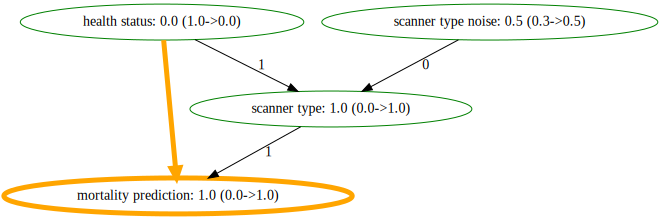

assign 0 credits to health status->mortality prediction


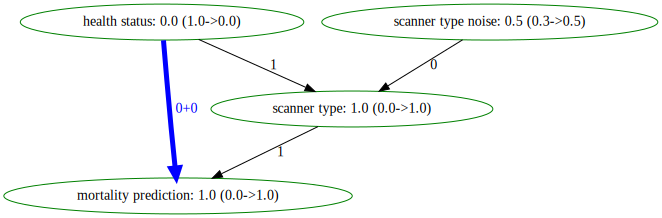

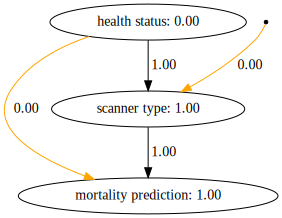

In [45]:
def build_health_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph: x1->x2, y = f(x1, x2)
    x1 = Node('health status')
    n2 = Node('scanner type noise', is_noise_node=True)
    x2 = Node('scanner type', lambda x1, n2: int(0.9 > n2) if x1 <= 0.1 else int(0.3 > n2), [x1, n2])
    y  = Node('mortality prediction', lambda x1, x2: x2, 
              [x1, x2], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([x1, n2, x2, y],
                 {
                     'health status': lambda: 1,
                     'scanner type noise': lambda: 0.3 # np.random.uniform(0, 1)
                 },
                 {
                     'health status': lambda: 0,
                     'scanner type noise': lambda: 0.5 # np.random.uniform(0, 1),
                 })
   
    return graph

graph = build_health_graph()
cf = CreditFlow(graph, verbose=True, nruns=1, visualize=True)
cf.run()

G = cf.credit2dot()
viz_graph(G)

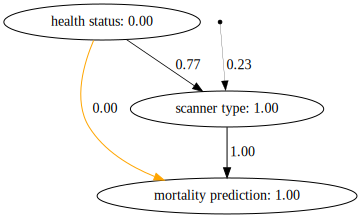

In [46]:
'''
current value: health status, scanner type, mortality
{
    (0, 1, 1): [(0-1, 0-0.89999)]
    (0, 0, 0): [(0-1. 0.9-1)]
}

to make sure value changes from (1, 0, 0) -> (0, 1, 1)
we need baseline noise 0.3-1
        target noise 0-0.899999
'''

def build_health_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph: x1->x2, y = f(x1, x2)
    x1 = Node('health status')
    n2 = Node('scanner type noise', is_noise_node=True)
    x2 = Node('scanner type', lambda x1, n2: int(0.9 > n2) if x1 <= 0.1 else int(0.3 > n2), [x1, n2])
    y  = Node('mortality prediction', lambda x1, x2: x2, 
              [x1, x2], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([x1, n2, x2, y],
                 {
                     'health status': lambda: 1,
                     'scanner type noise': lambda: np.random.uniform(0.3, 1)
                 },
                 {
                     'health status': lambda: 0,
                     'scanner type noise': lambda: np.random.uniform(0, 0.9),
                 })
   
    return graph

graph = build_health_graph()
cf = CreditFlow(graph, verbose=False, nruns=1000)
cf.run()

G = cf.credit2dot()
viz_graph(G)

Health status has limited effect in this case when

1. target noise < 0.3 (health status has no effect when applied second)
2. base noise > 0.9 (health status has no effect when applied first)

which has probablity $1/3 * 1/2 + 1/7 * 1/2 = 0.238$, matching the result we saw here in simulation.

# More realistic setup

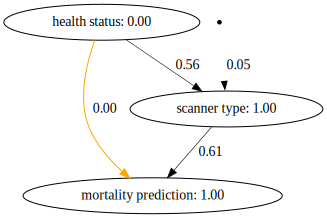

In [47]:
def build_health_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph: x1->x2, y = f(x1, x2)
    x1 = Node('health status')
    n2 = Node('scanner type noise', is_noise_node=True)
    x2 = Node('scanner type', lambda x1, n2: int(0.9 > n2) if x1 <= 0.1 else int(0.3 > n2), [x1, n2])
    y  = Node('mortality prediction', lambda x1, x2: x2, 
              [x1, x2], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([x1, n2, x2, y],
                 {
                     'health status': lambda: np.random.choice([0, 1], p=[0.1, 0.9]),
                     'scanner type noise': lambda: np.random.uniform(0, 1) # relax baseline
                 },
                 {
                     'health status': lambda: 0,
                     'scanner type noise': lambda: np.random.uniform(0, 0.9), # target is invariant
                 })
   
    return graph

graph = build_health_graph()
cf = CreditFlow(graph, verbose=False, nruns=1000)
cf.run()

G = cf.credit2dot()
viz_graph(G)

# More nodes

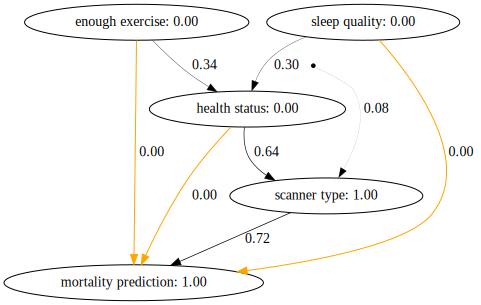

In [48]:
def build_health_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph: x1->x2, y = f(x1, x2)
    x00 = Node('enough exercise') # [0, 1]
    x01 = Node('sleep quality') # [0, 1]
    x1 = Node('health status', lambda x00, x01: x00 and x01, [x00, x01])
    n2 = Node('scanner type noise', is_noise_node=True)
    x2 = Node('scanner type', lambda x1, n2: int(0.9 > n2) if x1 <= 0.1 else int(0.3 > n2), [x1, n2])
    y  = Node('mortality prediction', lambda x00, x01, x1, x2: x2, 
              [x00, x01, x1, x2], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([x00, x01, x1, n2, x2, y],
                 {
                      'enough exercise': lambda: 1,
                      'sleep quality': lambda: 1, 
                     #'health status': lambda: np.random.choice([0, 1], p=[0.1, 0.9]),
                     'scanner type noise': lambda: np.random.uniform(0, 1) # relax baseline
                 },
                 {
                      'enough exercise': lambda: 0,
                      'sleep quality': lambda: 0,
                     #'health status': lambda: 0,
                     'scanner type noise': lambda: np.random.uniform(0, 0.9), # target is invariant
                 })
   
    return graph

graph = build_health_graph()
# graph = boundary_graph(graph)
cf = CreditFlow(graph, verbose=False, nruns=300)
cf.run()

G = cf.credit2dot()
viz_graph(G)

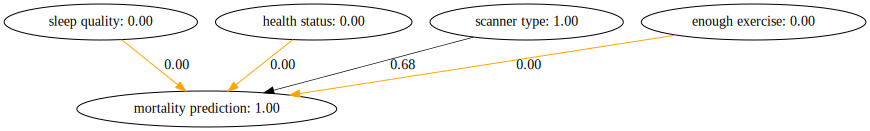

In [49]:
shap_graph = flatten_graph(graph)
verbose = False
cf = CreditFlow(shap_graph, verbose=verbose, nruns=300, visualize=verbose)
cf.run()

G = cf.credit2dot(format_str="{:.2f}")
viz_graph(G)

In [36]:
print('fix other variables but only change health status')
sources = get_source_nodes(graph)
d = dict((node.name, 1) for node in sources)
d.update({'health status': 0, 'scanner type noise': 0.4})
print(d)
print('output:', eval_graph(graph, d))

sources = get_source_nodes(graph)
d = dict((node.name, 1) for node in sources)
d.update({'health status': 1, 'scanner type noise': 0.4})
print(d)
print('output:', eval_graph(graph, d))

fix other variables but only change health status
{'scanner type noise': 0.4, 'enough exercise': 1, 'sleep quality': 1, 'health status': 0}
output: 1
{'scanner type noise': 0.4, 'enough exercise': 1, 'sleep quality': 1, 'health status': 1}
output: 0


Health status clearly affect the output. However, in SHAP and ASV, its contribution is 0. 

## Possible presentation in paper for this synthetic experiment?

#### Flaws with ASV and SHAP

1. ASV and Shap give no credit to intermediate variables
2. However, if we intervenue on those variables (fix others being the same), we observe non-trivial change in output prediction
3. This questions how credit assignment should work

Should a variable move credit from its downstream features to its upstream causes? Should correlation be used (could move credit from its upstream features to downstream features, NO)? If we answer no, we are dismissing the good arguments for on data manifold perturbations. If we answer yes, we lose sight of actual features that affect the model, which is dangenerous if the model is actually using unstable correlation. It is critical to see all views of a model.

Also, ASV no unique solution.

#### Aside from axioms, why Shapley flow is good?

From the system, it should be clear to see why a model is flawed, or how to fail the model in a non adversarial setting. It will be tricky to define what realistic means. We could do that with intervention (defining what nodes can be intervenued in the synthetic data). Let the user attack the model with just the model, or with any single view of the model.

Hopefully, Shapley Flow makes them easy to define interventions that changes the model output (a user's action is restricted to change foreground and background value). 

# Example of not implementation invariance

This fails shapley because the red edge can only appear first or last.

A simple graph


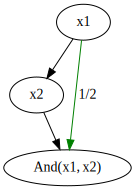

In [31]:
print('A simple graph')
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2')
dot.node('y', 'And(x1, x2)')

dot.edges(['12', '2y'])
dot.edge('1', 'y', color='green', label='1/2')
dot

sample baseline {'x1': 0, 'x2': 0, 'target': 0}
target values {'x1': 1, 'x2': 1, 'target': 1}


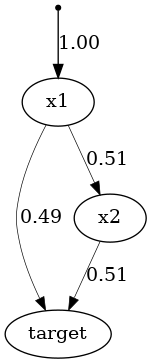

In [13]:
def build_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph
    x1 = Node('x1')
    x2 = Node('x2', lambda x1: x1, [x1])
    y  = Node('target', lambda x1, x2: int(x1 + x2 >= 2), 
              [x1, x2], is_target_node=True)

    # initialize the values from data: now is just specified
    graph = Graph([x1, x2, y], 
              # sample baseline
              lambda: {'x1': 0, 'x2': 0, 'target': 0},
              # target to explain
              {'x1': 1, 'x2': 1, 'target': 1})

    # verbose print
    baseline = graph.baseline_sampler()
    baseline[y.name] = y.f(*[arg.baseline for arg in y.args])
    print('sample baseline', baseline)
    print('target values', graph.target_values)

    # check the amount of noise
    check_baseline_target(graph)
    return graph

cf = CreditFlow(verbose=False, nruns=1000)
graph = build_graph()
cf.run(graph)

dot = cf.credit2dot()
dot.write_png('graph.png')
Image('graph.png')

adding an intermediate node from x1 to x2


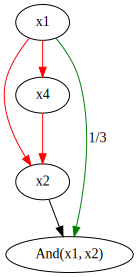

In [177]:
print('adding an intermediate node from x1 to x2')
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2')
# dot.node('3', 'x3')
dot.node('4', 'x4')
dot.node('y', 'And(x1, x2)')

dot.edges(['2y'])
dot.edge('1', 'y', color='green', label='1/3')
dot.edge('1', '4', color='red')
dot.edge('4', '2', color='red')
dot.edge('1', '2', color='red')
display(dot)

sample baseline {'x1': 0, 'x2': 0, 'x4': 0, 'target': 0}
target values {'x1': 1, 'x2': 1, 'x4': 1, 'target': 1}


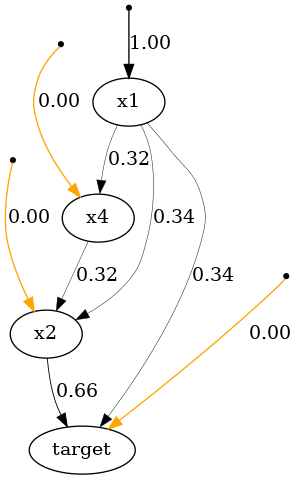

In [47]:
def build_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph
    x1 = Node('x1')
    x4 = Node('x4', lambda x1: x1, [x1])
    x2 = Node('x2', lambda x1, x4: (x4 + x1)/2, [x1, x4])
    y  = Node('target', lambda x1, x2: int(x1 + x2 >= 2), 
              [x1, x2], is_target_node=True)

    # initialize the values from data: now is just specified
    graph = Graph([x1, x2, x4, y], 
              # sample baseline
              lambda: {'x1': 0, 'x2': 0, 'x4': 0, 'target': 0},
              # target to explain
              {'x1': 1, 'x2': 1,  'x4': 1, 'target': 1})

    # verbose print
    baseline = graph.baseline_sampler()
    baseline[y.name] = y.f(*[arg.baseline for arg in y.args])
    print('sample baseline', baseline)
    print('target values', graph.target_values)

    # check the amount of noise
    check_baseline_target(graph)
    return graph

cf = CreditFlow(verbose=False, nruns=3000)
graph = build_graph()
cf.run(graph)

dot = cf.credit2dot()
dot.write_png('graph.png')
Image('graph.png')

works in this case: adding an intermediate node from x2 to yhat


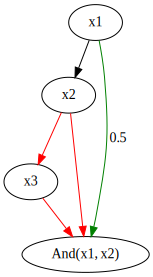

In [39]:
print('works in this case: adding an intermediate node from x2 to yhat')
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2')
dot.node('3', 'x3')
dot.node('y', 'And(x1, x2)')

dot.edges(['12'])
dot.edge('1', 'y', color='green', label='0.5')
dot.edge('2', '3', color='red')
dot.edge('2', 'y', color='red')
dot.edge('3', 'y', color='red')
dot

sample baseline {'x1': 0, 'x2': 0, 'x3': 0, 'target': 0}
target values {'x1': 1, 'x2': 1, 'x3': 1, 'target': 1}


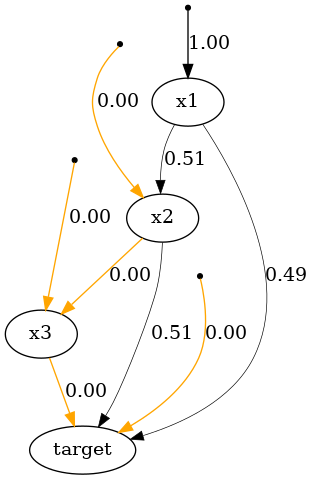

In [34]:
def build_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph
    x1 = Node('x1')
    x2 = Node('x2', lambda x1: x1, [x1])
    x3 = Node('x3', lambda x1: x1, [x2])
    y  = Node('target', lambda x1, x2, x3: int(x1 + x2 >= 2), 
              [x1, x2, x3], is_target_node=True)

    # initialize the values from data: now is just specified
    graph = Graph([x1, x2, x3, y], 
              # sample baseline
              lambda: {'x1': 0, 'x2': 0, 'x3': 0, 'target': 0},
              # target to explain
              {'x1': 1, 'x2': 1,  'x3': 1, 'target': 1})

    # verbose print
    baseline = graph.baseline_sampler()
    baseline[y.name] = y.f(*[arg.baseline for arg in y.args])
    print('sample baseline', baseline)
    print('target values', graph.target_values)

    # check the amount of noise
    check_baseline_target(graph)
    return graph

cf = CreditFlow(verbose=False, nruns=100)
graph = build_graph()
cf.run(graph)

dot = cf.credit2dot()
dot.write_png('graph.png')
Image('graph.png')

need to pad a copy input node before expanding the computation of x2


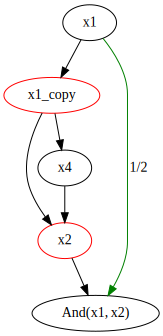

In [50]:
print('need to pad a copy input node before expanding the computation of x2')
dot = Digraph()
dot.node('1', 'x1')
dot.node('2', 'x2', color='red')
dot.node('3', 'x1_copy', color='red')
dot.node('4', 'x4')
dot.node('y', 'And(x1, x2)')

dot.edges(['2y'])
dot.edge('1', 'y', color='green', label='1/2')
dot.edge('1', '3')
dot.edge('3', '4')
dot.edge('4', '2')
dot.edge('3', '2')
dot

sample baseline {'x1': 0, 'x2': 0, 'x4': 0, 'x1_copy': 0, 'target': 0}
target values {'x1': 1, 'x2': 1, 'x4': 1, 'target': 1, 'x1_copy': 1}


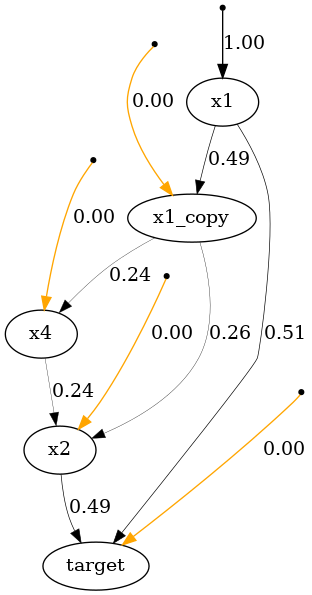

In [52]:
def build_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph
    x1 = Node('x1')
    x1_copy = Node('x1_copy', lambda x1: x1, [x1])
    x4 = Node('x4', lambda x1_copy: x1_copy, [x1_copy])
    x2 = Node('x2', lambda x1_copy, x4: (x4 + x1_copy) / 2, [x1_copy, x4])
    y  = Node('target', lambda x1, x2: int(x1 + x2 >= 2), 
              [x1, x2], is_target_node=True)

    # initialize the values from data: now is just specified
    graph = Graph([x1, x2, x1_copy, x4, y], 
              # sample baseline
              lambda: {'x1': 0, 'x2': 0, 'x4': 0, 'x1_copy': 0, 'target': 0},
              # target to explain
              {'x1': 1, 'x2': 1,  'x4': 1, 'target': 1, 'x1_copy': 1})

    # verbose print
    baseline = graph.baseline_sampler()
    baseline[y.name] = y.f(*[arg.baseline for arg in y.args])
    print('sample baseline', baseline)
    print('target values', graph.target_values)

    # check the amount of noise
    check_baseline_target(graph)
    return graph

cf = CreditFlow(verbose=False, nruns=1000)
graph = build_graph()
cf.run(graph)

dot = cf.credit2dot()
dot.write_png('graph.png')
Image('graph.png')